# **RSNA 2022: Deep Learning Lab**

## **NLP: Text Classification with Transformers**

In this demonstration, we will utilize techniques of *natural language
processing* (NLP) to train a classifier, which will analyze the text of
radiology reports for chest radiographs to predict whether a report is
**normal** or **abnormal**.

### Code

We will utilize four libraries from **HuggingFace**:
[Transformers](https://huggingface.co/transformers/),
[Accelerate](https://huggingface.co/docs/accelerate/en/index),
[Datasets](https://huggingface.co/datasets), and
[Evaluate](https://huggingface.co/docs/evaluate/en/package_reference/main_classes).
These libraries are written primarily in the [Python programming
language](https://www.python.org/) and can be used with both the
[PyTorch](https://www.pytorch.org/) and
[TensorFlow](https://www.tensorflow.org/) deep learning libraries.

The demonstration in this notebook relies heavily on examples from the
[HuggingFace Course](https://huggingface.co/course/chapter1).

### Data

The data is obtained from the National Library of Medicine’s Open-i
service. We utilize the radiology reports from the [Indiana University
Chest X-ray Dataset](https://openi.nlm.nih.gov/faq#collection) for this
demonstration.

> *Reference:* Demner-Fushman D, Kohli MD, Rosenman MB, Shooshan SE,
> Rodriguez L, Antani S, Thoma GR, McDonald CJ. Preparing a collection
> of radiology examinations for distribution and retrieval. J Am Med
> Inform Assoc. 2016 Mar;23(2):304-10. doi: 10.1093/jamia/ocv080. Epub
> 2015 Jul 1.

### Developer

-   Walter F. Wiggins, MD, PhD - Duke University Hospital, Durham, NC,
    USA

### Acknowledgements

-   Felipe Kitamura, MD - UNIFESP, Sao Paulo, Brasil
-   Igor Santos, MD - UNIFESP, Sao Paulo, Brasil
-   Luciano M. Prevedello, MD, MPH - Ohio State University, Columbus,
    OH, USA

## Interactive Participation

This notebook is designed for interactive participation.

Please refer to the previous posts on [installing
Python](/posts/install-python.qmd) and [installing PyTorch and
fast.ai](/posts/install-pytorch.qmd) with `uv` to ensure your
environment is set up properly. You’ll also need to run the following
commands to add four additional packages to your `uv` project.

``` sh
uv add "transformers>=4.57.6"
uv add "accelerate>=1.12.0"
uv add "datasets>=4.5.0"
uv add "evaluate>=0.4.6"
```

If you haven’t yet done the previous [interactive tutorial on
RNNs](/posts/rnns_tutorial.ipynb), you’ll also need to run the following
command; however, it is highly recommended to do that one first, as some
key concepts in NLP are covered within that will help you understand
this tutorial.

``` sh
uv add xmltodict
```

**Note: You’ll want to download this notebook to the same folder where
your `uv` project lives.**

To run Jupyter Lab and open the notebook within your `uv` project, run
the following command in your terminal.

``` sh
uv run --with jupyter jupyter lab
```

You can run the code cells in order, and modify parameters as desired to
see how they affect the results.

If you are using Google Colab, please use the link below to open a
compatible version in Colab. You can save a copy of the notebook to your
own Google Drive by selecting “File” -\> “Save a copy in Drive”.

[Open in
Colab](https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2023/blob/main/sessions/nlp-text-classification/RSNA22_NLP_Transformers.ipynb)

# Downloading the Data

When you run the following cell, the [NLM Open-i “Indiana University
Chest X-ray Reports” dataset](https://openi.nlm.nih.gov/faq#collection)
will be downloaded.

In [1]:
%%capture

import warnings
warnings.filterwarnings("ignore")

# Download the data
!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz


# Reformatting the Data

Each of the reports is stored in *extensible markup language* (XML)
format. In order to work with the report text data more easily, we will
extract the data and put it into a `pandas.DataFrame`, which is a
tabular data structure.

The XML metadata contains [MeSH
terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use
these to create the *label* for each report in our dataset. These labels
will serve as the targets for training our classifier to predict whether
the report is **normal** or **abnormal**.

After the relevant data is extracted from the XML files, the total
number of reports and the first 5 rows of our data table will show up
below.

In [2]:
import glob
import xmltodict
import pandas as pd
from fastcore.foundation import L

# suppress warnings from the output
import warnings
warnings.filterwarnings('ignore')


def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text_dict['report_id'] = report['eCitation']['IUXRId']['@id']
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['labels'] = label
    return report_dict

fps = L(glob.glob('./ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report)).set_index('report_id').sort_index()
print('# of reports:', reports_df.shape[0])
print()
reports_df.head()

# of reports: 3955


# Exploring the data

Let’s look through a little more of the data to get a feel for what
we’re working with and how we might want to design the subsequent model
training experiments.

We’ll then take a look at how many normals and abnormals we have to work
with.

In [3]:
# Run this cell several times to view random samples of the data

reports_df.sample(5)

Here are some of the things you may have noticed about the data, as you
reviewed it: - Some reports only have an Impression (i.e. no separate
Findings section) - Many reports contain blocks of “XXXX” text. This is
due to the fact that these reports were anonymized prior to releasing
them as an open data set. These blocks likely represent *named entities*
or dates. - As expected, there is wide variation in the length of these
chest radiograph reports.

Importantly, there are some reports where the “Impression” states
something along the lines of “No acute cardiopulmonary abnormality” but
the label is “abnormal”. It seems like this is usually due to a chronic
incidental finding or artifact that is mentioned in the “Findings”, but
isn’t included in the “Impression”.

> We’ll revisit this point later when we’re deciding which text from the
> report we want to use to train our classifier.

Next, let’s count how many of each label we have.

Abnormal: 2564
Normal: 1391


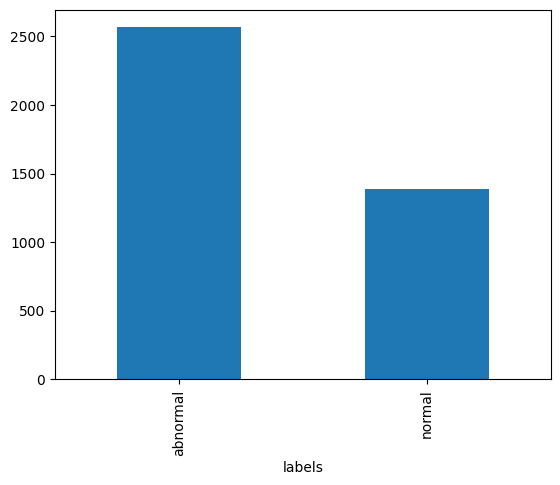

In [4]:
label_counts = reports_df.labels.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many
abnormal reports as there are normal reports. This will be important to
remember as we partition our data into training, validation, and test
sets.

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text.
Therefore, we need a way to convert text into numbers. We also want a
way for those numbers to contain a little more information about the
text they represent. Here, we’ll describe the steps in preparing our
text for *language modeling*.

## Tokenization

*Tokenization* is the process by which we split text into chunks or
*tokens*. An individual token could be a sentence or phrase, a word, a
part of a word, or a single character. Most often, we choose to tokenize
at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of
token-integer pairs is called our *vocabulary*.

## DistilBERT Tokenization

In this case, since we’re training a transformer model, we will use a
different tokenizer designed specifically for this task from the
HuggingFace Transformers library.

In [5]:
from transformers import DistilBertTokenizerFast

text = reports_df.sample()['full-text'].values[0]
print(text)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
print("Tokenizer vocab size:", len(tokenizer))
ids = tokenizer.encode(text, padding=True, truncation=True, return_tensors='pt')
print(ids[0])
print(tokenizer.decode(ids[0]))

Stable cardiomegaly with left-sided implanted ICD. Hilar pulmonary venous vasculature stable compared to prior examination. No focal consolidation, pneumothorax, or large pleural effusions identified. No acute osseous abnormality is identified. Stable cardiomegaly without evidence of overt heart failure/pulmonary edema.
Tokenizer vocab size: 30522
tensor([  101,  6540,  4003, 18994, 29107,  2135,  2007,  2187,  1011, 11536,
        27159,  2098, 24582,  2094,  1012,  7632,  8017, 21908,  2310, 18674,
        12436, 28817, 20051,  5397,  6540,  4102,  2000,  3188,  7749,  1012,
         2053, 15918, 17439,  1010,  1052,  2638,  2819, 29288,  2527,  2595,
         1010,  2030,  2312, 20228, 11236,  2389,  1041,  4246, 22016,  4453,
         1012,  2053, 11325,  9808,  3366,  3560, 19470,  3012,  2003,  4453,
         1012,  6540,  4003, 18994, 29107,  2135,  2302,  3350,  1997,  2058,
         2102,  2540,  4945,  1013, 21908,  3968, 14545,  1012,   102])
[CLS] stable cardiomegaly with l

## Embedding

While these integers map one-to-one onto our tokens, their numeric value
is otherwise meaningless. To embed more information into the numeric
representation of our tokens, we employ a process called *language
modeling*. We can either use a pre-trained language model for this
*embedding* or we can fine-tune a language model to better model our
“radiology language”. This latter process is called *transfer learning*.

# Report Classifier Training

In the steps that follow, we will fine-tune a pretrained model as a text
classifier, using the embeddings from the model’s pretraining. We will
then test the classifier on our held-out test set to see how it performs
on data it hasn’t seen yet.

This is different that how we did this in the RNNs tutorial, where we
first fine-tuned a language model on the task of next token prediction
to optimize embeddings, and then went on to train the classifier using
those fine-tuned embeddings.

We skip that step to showcase the power and flexibility of Transformer
models. We don’t even have to fine-tune the underlying language model to
get a very accurate classifier.

In [6]:
# We'll use the Hugging Face datasets library to create our datasets
from datasets import Dataset

dset = Dataset.from_pandas(reports_df)
dset

Dataset({
    features: ['findings', 'impression', 'full-text', 'labels', 'report_id'],
    num_rows: 3955
})

Here we perform our train-validation-test splits with a built-in method
similar to the `scikit-learn` function

In [7]:
dsets = dset.train_test_split(test_size=0.15, seed=42)
dsets_clean = dsets["train"].train_test_split(test_size=0.30, seed=42)
dsets_clean["validation"] = dsets_clean.pop("test")
dsets_clean["test"] = dsets["test"]
dsets_clean

DatasetDict({
    train: Dataset({
        features: ['findings', 'impression', 'full-text', 'labels', 'report_id'],
        num_rows: 2352
    })
    validation: Dataset({
        features: ['findings', 'impression', 'full-text', 'labels', 'report_id'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['findings', 'impression', 'full-text', 'labels', 'report_id'],
        num_rows: 594
    })
})

Next, we take our categorical labels and wrap them in a class that
easily converts back and forth between numerical representation and text

In [8]:
from datasets import ClassLabel

label_names = ['normal', 'abnormal']
labels = ClassLabel(names=label_names)
labels

ClassLabel(names=['normal', 'abnormal'])

Here we define a function to tokenize our dataset in batches.

``` callout-tip
To see how the model performs with different inputs from the report try replacing 'impression' with 'full-text'.
```

In [9]:
def preprocess(batch):
    tokens = tokenizer(batch['impression'], truncation=True, max_length=128)  # try 'full-text', 'impression', or 'findings' here
    tokens['labels'] = labels.str2int(batch['labels'])
    return tokens


In [10]:
tokenized_dsets = dsets_clean.map(preprocess, batched=True)
tokenized_dsets

DatasetDict({
    train: Dataset({
        features: ['findings', 'impression', 'full-text', 'labels', 'report_id', 'input_ids', 'attention_mask'],
        num_rows: 2352
    })
    validation: Dataset({
        features: ['findings', 'impression', 'full-text', 'labels', 'report_id', 'input_ids', 'attention_mask'],
        num_rows: 1009
    })
    test: Dataset({
        features: ['findings', 'impression', 'full-text', 'labels', 'report_id', 'input_ids', 'attention_mask'],
        num_rows: 594
    })
})

## Setting up the Training Run

1.  We define a metrics function to output accuracy and F1-score during
    training and validation.
2.  We then configure our training experiment with a variety of
    hyperparameters. For more information on the different arguments,
    please see the
    [docs](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments)
    for `TrainingArguments`.

``` callout-tip
Try editing the hyperparameters with different options for arguments like `num_train_epochs` and `learning_rate` to see the effect these have on training. 

For example, if you set `learning_rate` too low or too high, the model may fail to learn. 

If it looks like your model is overfitting (i.e. validation loss goes up and validation metrics stop improving), then you might try reducing `num_train_epochs`.
```

In [11]:
import numpy as np
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from evaluate import load

# This metrics function will output accuracy and F1-score during training & validation
metric = load("glue", "mrpc")

def compute_metrics(eval_pred):
    logits = getattr(eval_pred, "predictions", eval_pred[0])
    labels = getattr(eval_pred, "label_ids", eval_pred[1])
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

# This step configures our training experiment
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_strategy="steps",
    logging_steps=10,
    logging_first_step=True,
    disable_tqdm=False,
    eval_strategy='epoch',
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    warmup_ratio=0.06,
    logging_nan_inf_filter=False,
)


## Running the Training Experiment

Now we select our model and run the training experiment. You’ll see a
warning printed out telling you that you should “*probably TRAIN this
model on a down-stream task to be able to use it for predictions and
inference*”. And that is **exactly** what we’re doing, so we can safely
disregard.

In [12]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dsets['train'],
    eval_dataset=tokenized_dsets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_output = trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [13]:
# Finally we save our trained model for later use
trainer.save_model('fine-tuned')


## Testing the model

Now that our model is trained, let’s test it on our held-out test
dataset.

In [14]:
test_output = trainer.predict(tokenized_dsets['test'])
print(test_output.metrics)

{'test_loss': 0.460722953081131, 'test_accuracy': 0.7373737373737373, 'test_f1': 0.7671641791044777, 'test_runtime': 1.4694, 'test_samples_per_second': 404.253, 'test_steps_per_second': 6.806}

# Creating a Pipeline for Inference

In [15]:
from transformers import pipeline

classifier = pipeline("text-classification", model="fine-tuned")
classifier.model.config.id2label = {0: 'normal', 1: 'abnormal'}

Device set to use mps:0

In [16]:
test = tokenized_dsets['test']
print("Ground Truth Label:", labels.int2str(test[0]['labels']))
print()
print("Report text:", test[0]['impression'])

Ground Truth Label: abnormal

Report text: Chronic lung disease, with no acute cardiopulmonary findings.

In [17]:
classifier(test[0]['impression'])

[{'label': 'abnormal', 'score': 0.9953399896621704}]

In [18]:
# Modify this cell with some sample text of your choosing to test out the model
sample_text = "Normal heart size and mediastinal contours. The lungs are well-aerated. No pleural effusion or pneumothorax. No displaced rib fractures."
classifier(sample_text)

[{'label': 'normal', 'score': 0.9815007448196411}]